In [154]:
import numpy as np
import matplotlib.pyplot as plt


##define the fixed parameters
hatchability = 0.98  #if hatchability is density (egg or adult) depedent, then define it in the pre-adult-module or the adult-module functions 
x1 = 2.5  #parameter in finding the mean larval size
x2 = 1  #parameter in finding the mean larval size 
x3 = 0.009 #parameter in finding the mean larval size 
sigma_size = 0.45  #parameter in assigning larval sizes by drawing from a normal distribution
mc = 1.1 #critical size cut off of the larval stage for successful pupation (= 1.1 (JB) and 1 (FEJ))
x4 = 1.0  #parameter in finding the adult sizes
female_proportion = 0.5 #assign sex to the adutls 
x5 = 85 #parameter in finding fecundity
x6 = 2  #parameter in finding fecundity
sen_adsize = 1.7 #parameter related to sensivity of fecundity to adult size
sen_adden = 0.17 #parameter related to sensivity of fecundity to adult denisity


initial_number_of_eggs_per_patch = 100

food = 1.76
adnut = 1


migration_fraction = 0.2

number_of_replicates = 4
number_of_generations = 100

In [155]:
##Pre-Adult-Module
#food = larval food amt; 1.76 (LL and LH), 2.56 (HL and HH) 

"""  
This function takes the number of eggs in gen t and larval food amount as input and returns the number of adults in gen t and their size distribution as output.

Args: 
    numegg (int): number of eggs in generation t
    food (float): larval food amount in ml

Returns:
    numadult (int): number of adults in generation t
    size_adult_arr (array): size distribution of adults in generation t
"""
def assign_sex_to_size_array(numadult):
        adult_sex_arr = np.random.binomial(size=numadult, n=1, p=female_proportion) # 1 is a female and 0 a male
        return adult_sex_arr


def pre_adult_module_egg_to_adult(numegg,food):
    numlarva = int(hatchability*numegg)
    mean_size = x1*(1-1/(x2+np.exp(-x3*numlarva+food)))
    size_larva_arr = abs(np.random.normal(mean_size, sigma_size, numlarva))
    
    size_adult_arr = x4*size_larva_arr[size_larva_arr>=mc]
    numadult = len(size_adult_arr)


    adult_sex_arr = assign_sex_to_size_array(numadult)

    fly_sex_and_size = [{'size': size, 'sex': sex} for size, sex in zip(size_adult_arr, adult_sex_arr)]


        
    return fly_sex_and_size


In [156]:
def from_list2_subtract_list1(list2, list1):
    for item in list1:
        if item in list2:
            list2.remove(item)
    return list2



In [157]:
def migration(patch1, patch2, migration_fraction):
    
    female_flies_1 = [fly for fly in patch1 if fly['sex'] == 1]
    female_flies_2 = [fly for fly in patch2 if fly['sex'] == 1]

    num_migrating_flies_1_to_2 = round(len(female_flies_1) * migration_fraction)
    num_migrating_flies_2_to_1 = round(len(female_flies_2) * migration_fraction)

    #check if really round

    migrating_flies_1_to_2 = np.random.choice(female_flies_1, num_migrating_flies_1_to_2, replace=False)
    migrating_flies_2_to_1 = np.random.choice(female_flies_2, num_migrating_flies_2_to_1, replace=False)

    patch1 = from_list2_subtract_list1(patch1, migrating_flies_1_to_2)
    patch2 = from_list2_subtract_list1(patch2, migrating_flies_2_to_1)

    patch2.extend(migrating_flies_1_to_2)
    patch1.extend(migrating_flies_2_to_1)   #add incoming flies to the patch

    return patch1, patch2

In [158]:
def adult_module_females_laying_eggs(flies_sex_and_size,adnut):
    #no extinction for now

    number_of_adults = len(flies_sex_and_size)
    fecundity_array = []

    '''
    if numadult == 0: # if the population goes extinct then restart it with 4 females of size 2*mc
        numadult = 4
        size_female_arr = 2*mc*np.ones(numadult) 
    '''
    
    if number_of_adults > 0 :   
      
        size_female_array =  [fly['size'] for fly in flies_sex_and_size if fly['sex'] == 1]
        size_female_array = np.array(size_female_array)

        adult_density_independant_fecundity_array = adnut*x5*np.log(x6+sen_adsize*size_female_array)
        fecundity_array = adult_density_independant_fecundity_array


    #for now no density dependance of fecundity
    '''

    addens_eff = 1/(1+sen_adden*numadult)
    fecundity_arr = addens_ind_fec_arr*addens_eff

'''
    number_of_eggs = fecundity_array.sum()
    return number_of_eggs

In [159]:
def two_patch_metapopulation_simulation(number_of_generations):

    population_data_for_each_generation = []

    number_of_eggs_patch_1 = initial_number_of_eggs_per_patch
    number_of_eggs_patch_2 = initial_number_of_eggs_per_patch

    for generation in range(number_of_generations):
        patch1_adults_list_sex_and_size = pre_adult_module_egg_to_adult(number_of_eggs_patch_1, food)
        patch2_adults_list_sex_and_size = pre_adult_module_egg_to_adult(number_of_eggs_patch_2, food)

        patch1_number_of_adults = len(patch1_adults_list_sex_and_size)
        patch2_number_of_adults = len(patch2_adults_list_sex_and_size)

        total_number_of_adults = patch1_number_of_adults + patch2_number_of_adults  


        #census
        population_data_for_each_generation.append({"generation": generation + 1, "patch_1_number_of_adults": patch1_number_of_adults, "patch_2_number_of_adults" : patch2_number_of_adults, "total_number_of_adults": total_number_of_adults})

        #migration
        patch1_adults_list_sex_and_size, patch2_adults_list_sex_and_size = migration(patch1_adults_list_sex_and_size, patch2_adults_list_sex_and_size, migration_fraction)
        
        #laying_eggs
        number_of_eggs_patch_1 = adult_module_females_laying_eggs(patch1_adults_list_sex_and_size, adnut)
        number_of_eggs_patch_2 = adult_module_females_laying_eggs(patch2_adults_list_sex_and_size, adnut)

       

    return population_data_for_each_generation


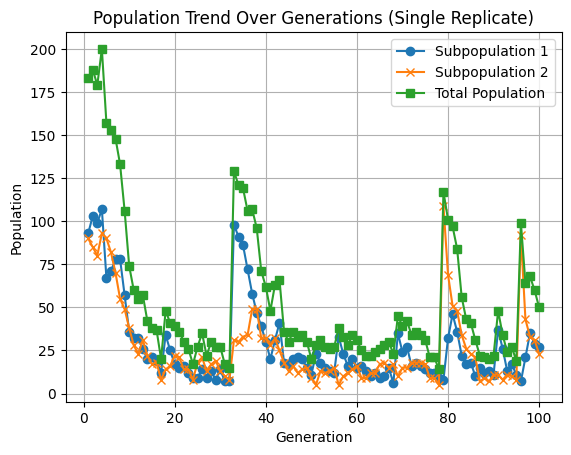

In [160]:
def plot_population_patch1_patch2_and_total_for_one_replicate(population_data_for_each_generation):
    
    generation_numbers = np.arange(1, number_of_generations + 1)

    patch1_number_of_adults_list_per_generation = []
    patch2_number_of_adults_list_per_generation = []
    total_number_of_adults_list_per_generation = []

    for generation in range(number_of_generations):
        generation_data = population_data_for_each_generation[generation]

        patch1_number_of_adults_list_per_generation.append(generation_data['patch_1_number_of_adults'])
        patch2_number_of_adults_list_per_generation.append(generation_data['patch_2_number_of_adults'])
        total_number_of_adults_list_per_generation.append(generation_data['total_number_of_adults'])

 

    # Plot subpopulation 1
    plt.plot(generation_numbers, patch1_number_of_adults_list_per_generation, marker='o', label='Subpopulation 1')

    # Plot subpopulation 2
    plt.plot(generation_numbers, patch2_number_of_adults_list_per_generation, marker='x', label='Subpopulation 2')

    # Plot total population
    plt.plot(generation_numbers, total_number_of_adults_list_per_generation, marker='s', label='Total Population')

    plt.xlabel('Generation')
    plt.ylabel('Population')
    plt.title('Population Trend Over Generations (Single Replicate)')
    plt.legend()
    plt.grid(True)
    plt.show()



population_data_for_each_generation = two_patch_metapopulation_simulation(number_of_generations)
plot_population_patch1_patch2_and_total_for_one_replicate(population_data_for_each_generation)


In [161]:
def replicate_simulations_two_patch_metapopulations(number_of_replicates):
    replicate_data = []
    for replicate in range(number_of_replicates):
        replicate_data.append(two_patch_metapopulation_simulation(number_of_generations))
    return replicate_data

I can test this code by running it with just 1 patch and see if trends follow the trend of the previous 1 patch code